In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

In [3]:
path = "D:/04_DATA/01_LIVE_BACTERIAL_IMAGING/230510/"

In [2]:
dir_names = os.listdir("D:/04_DATA/01_LIVE_BACTERIAL_IMAGING/230510")

In [17]:
filtered = [d for d in dir_names if ("image1"  in d and "log" in d)]

In [18]:
class Tile:
    def __init__(self, image_paths, log_path, x, y, stacks, microns_per_pixel, z_step):
        self.image_paths = image_paths
        self.channels = np.asarray([self._load_image(image) for image in image_paths])
        self.imshape = self.channels[0][0,:,:].shape
        self.micoords = x, y
        self.PIXELS_PER_MICRON = 1 / microns_per_pixel
        self.pxcoords = x*self.PIXELS_PER_MICRON, y*self.PIXELS_PER_MICRON
        #self._adjust_y()
        self.n_stacks = stacks
        self.z_step = z_step
        

    def _load_image(self, image_path):
        return np.asarray(cv2.imreadmulti(image_path)[1])
    
    def _adjust_y(self):
        self.pxcoords = (self.pxcoords[0], self.pxcoords[1] - self.imshape[1])
        

In [6]:
def parse_file(path, filename):
    with open(path + filename, 'r') as f:
        ind = 0
        channels = []
        for line in f:
            line = line.strip()

            if ind > 0:
                a = line.split()
                x = float(a[1])
                y = float(a[2])
                channels.append(path + ' '.join(a[6:]))
                ind -= 1

            if line.startswith("Z Planes"):
                z = int(line.split()[2])
            if line.startswith("Microns Per Pixel:"):
                mpp = float(line.split()[3])
            if line.startswith("Z Step"):
                z_step = float(line.split()[4])
            if line.startswith("Channels"):
                n_channels=int(line.split()[1])
            if line.startswith("IFD"):
                ind = n_channels

        f.close()
    return Tile(channels, path+filename, x, y, z, mpp, z_step)    

In [33]:
class Image:
    def __init__(self, tiles):
        self.tiles = tiles
        self.tile_shape = (self.tiles[0].imshape[1], self.tiles[0].imshape[0])
        self.canvas_width, self.canvas_height = self._adjust_tile_coords()
        self.canvas = np.zeros((self.tiles[0].channels.shape[0], self.tiles[0].n_stacks, self.canvas_height, self.canvas_width), dtype="uint8")
        self.canvas_layout = np.zeros((self.tiles[0].channels.shape[0], self.tiles[0].n_stacks, self.canvas_height, self.canvas_width), dtype="float32")

    def stitchatron_9000(self):
        for tile in self.tiles:
            self.canvas[:, :, tile.pxcoords[1]:tile.pxcoords[1]+self.tile_shape[1], 
                        (self.canvas_width - tile.pxcoords[0] - self.tile_shape[0]):(self.canvas_width - tile.pxcoords[0])] += tile.channels
            self.canvas_layout[:, :, tile.pxcoords[1]:tile.pxcoords[1]+self.tile_shape[1], 
                        (self.canvas_width - tile.pxcoords[0] - self.tile_shape[0]):(self.canvas_width - tile.pxcoords[0])] += 1
        self.canvas_layout[self.canvas_layout == 0] = 1
        self.canvas = self.canvas // np.sqrt(self.canvas_layout)

    def _adjust_tile_coords(self):
        minx = np.min([tile.pxcoords[0] for tile in self.tiles])
        miny = np.min([tile.pxcoords[1] for tile in self.tiles])
        for tile in self.tiles:
            tile.pxcoords = (int(tile.pxcoords[0]-minx), int(tile.pxcoords[1]-miny))
        return np.max([tile.pxcoords[0] for tile in self.tiles]) + self.tile_shape[0], \
                np.max([tile.pxcoords[1] for tile in self.tiles]) + self.tile_shape[1]

        

In [19]:
tiles = [parse_file(path, f) for f in filtered]

In [35]:
im1 = Image(tiles)

In [36]:
im1.stitchatron_9000()

In [37]:
max_proj = np.max(im1.canvas[0,:,:,:], axis=0)

In [38]:
max_proj2 = np.max(im1.canvas[1,:,:,:], axis=0)

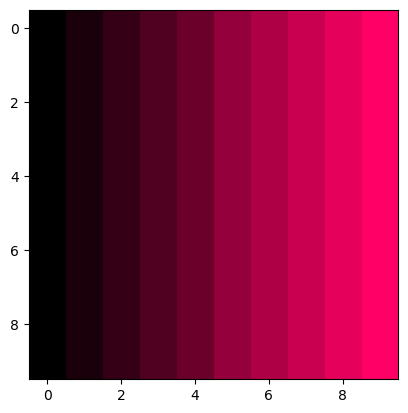

In [39]:
from matplotlib.colors import LinearSegmentedColormap

colors = [(0, 0, 0), (1, 0, 0.4)] # first color is black, last is red
cm = LinearSegmentedColormap.from_list(
        "Custom", colors, N=20)
mat = np.indices((10,10))[1]
plt.imshow(mat, cmap=cm)
plt.show()

In [47]:
[tile.pxcoords for tile in tiles]

[(0, 47),
 (400, 46),
 (823, 11),
 (1228, 11),
 (1585, 11),
 (1872, 11),
 (2108, 0),
 (2588, 29)]

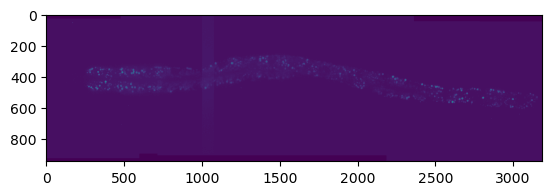

In [44]:
plt.imshow(max_proj2, vmin=0, vmax=50, cmap="viridis")
plt.savefig("test_img.png", dpi=1200)

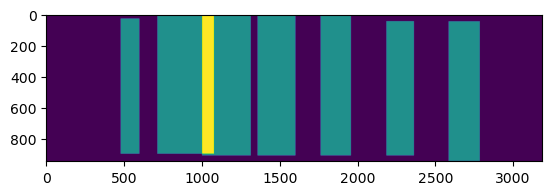

In [46]:
plt.imshow(im1.canvas_layout[0,0,:,:])

In [48]:
np.max(im1.canvas_layout)

3.0

In [133]:
im1._adjust_tile_coords()

In [150]:
im1.canvas_width, im1.canvas_height

(1703, 4611)

In [3]:
img = cv2.imreadmulti("D:/04_DATA/01_LIVE_BACTERIAL_IMAGING/230426/LOG_image2 - Position 1_0_14405.10-676.90.tif")

In [7]:
canvas = np.ndarray((38, 1000, 1000), dtype='uint8')

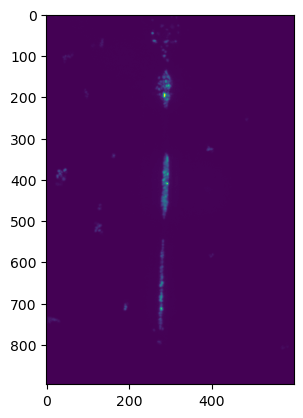

In [11]:
plt.imshow(np.max(img, axis=0))

In [8]:
canvas[:, :896, :600] = img

In [52]:
canvas = np.max(canvas, axis=0)

In [53]:
canvas.shape

(1000, 1000)

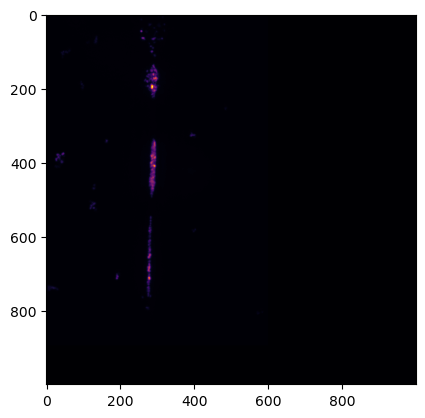

In [54]:
plt.imshow(canvas, cmap="inferno")

In [33]:
np.max(canvas)

234